# Training Deep Neural Networks on a GPU

## Preparing Data

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

In [13]:
dataset = MNIST(root='./data',
               download=False,
               transform=ToTensor())

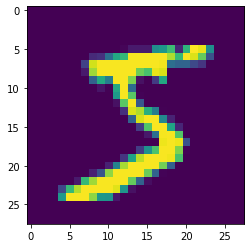

In [14]:
plt.imshow(dataset.data[0])

In [15]:
# FUnction that randomly picks a given fraction of the images for the validation set
def split_indices(n, val_pct):
    #Determine size of validation set
    n_val = int(val_pct*n)
    #Create random permutation of 0 to n-1
    idxs = np.random. permutation(n)
    #Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [16]:
train_indices, val_indices = split_indices(len(dataset),val_pct=0.2)
print(len(train_indices),len(val_indices))
print('Sample val indices ', val_indices[:20])

48000 12000
Sample val indices  [24933 11995 21589 56375 13335 41421 44722 41682 36772 41604 30676 24773
  9105 22967 19199 25438  2508 33804 39895 17861]


In [86]:
batch_size = 100

#Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                          batch_size,
                          sampler=train_sampler
)

#Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                       batch_size,
                       sampler=val_sampler)

## Model

In [35]:
import torch.nn as nn


input_size = 28*28
num_classes = 10

#Logistic regression model
model = nn.Linear(input_size,num_classes)

In [36]:
import torch.nn.functional as F
import torch.nn as nn

In [37]:
class MnistModel(nn.Module):
    """Feedfoward neuaral network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size,out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size,hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size,out_size)
        
    def forward(self, xb):
        #Flatten the image tensors
        xb = xb.view(xb.size(0),-1)
        #Get the intermediate outputs using hidden layer
        out = self.linear1(xb)
        #Apply the activation function
        out = F.relu(out)
        #Get predictions using output layer
        out = self.linear2(out)
        return out


In [38]:
input_size = 784
num_classes = 10

model = MnistModel(input_size,hidden_size=32,
                   out_size=num_classes)

Model parameters

In [39]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [40]:
for images, labels in train_loader:
    print('Images.shape',images.shape)
    outputs = model(images)
    loss = F.cross_entropy(outputs,labels)
    print('Loss: ', loss.item())
    break

print('Output.shape: ', outputs.shape)
print('Sample Outputs:\n', outputs[:2].data)

Images.shape torch.Size([100, 1, 28, 28])
Loss:  2.30692195892334
Output.shape:  torch.Size([100, 10])
Sample Outputs:
 tensor([[-0.2306,  0.1421,  0.1584, -0.2860, -0.1022, -0.1719, -0.0225, -0.2390,
         -0.1212,  0.1950],
        [-0.1900,  0.0724,  0.1927, -0.1816, -0.0510, -0.1439,  0.0377, -0.2474,
         -0.0970,  0.1953]])


## Using GPU

In [41]:
torch.cuda.is_available()

False

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [43]:
device = get_default_device()
device

device(type='cpu')

Function that can move data and model to a chosen device

In [44]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [45]:
to_device([torch.tensor([1,2,3,4]),torch.tensor([1,2,3,4])],device)

[tensor([1, 2, 3, 4]), tensor([1, 2, 3, 4])]

In [47]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cpu


In [48]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader,device):
        self.dataloader = dataloader
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to a device"""
        for batch  in self.dataloader:
            yield to_device(batch,self.device)
    
    
    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [51]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

In [53]:
for xb, yb in valid_dl:
    print('xb.device:',xb.device)
    print('yb:',yb)
    break

xb.device: cpu
yb: tensor([3, 8, 8, 5, 8, 8, 3, 5, 9, 2, 5, 4, 4, 4, 7, 9, 1, 8, 8, 3, 4, 1, 4, 0,
        3, 6, 1, 0, 3, 8, 1, 0, 8, 5, 5, 2, 1, 5, 7, 6, 1, 2, 1, 1, 1, 5, 2, 4,
        9, 3, 7, 6, 1, 6, 7, 4, 4, 4, 2, 3, 2, 3, 9, 6, 1, 4, 1, 7, 3, 8, 6, 7,
        7, 9, 2, 0, 4, 7, 3, 7, 4, 7, 1, 2, 1, 4, 1, 1, 2, 1, 7, 5, 7, 7, 4, 1,
        5, 6, 9, 7])


## Training the model

In [109]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Calculate loss
    preds = model(xb)
    loss = loss_func(preds,yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        #Update parameters
        opt.step()
        #Reset gradients
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        #Compute the metric
        metric_result = metric(preds,yb)
    
    return loss.item(), len(xb), metric_result

In [110]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #Pass each batch throuh the model
        
        results = [loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
        #Separate losses, count and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses,nums)) / total
        avg_metric = None
        if metric is not None:
            #Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics,nums)) / total
        return avg_loss, total, avg_metric

In [111]:
def fit(epochs,lr,model,loss_fn,train_dl,
        valid_dl,metric=None, opt_fn=None):
    losses,metrics = [],[]
    
    #Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(),lr)
    
    for epoch in range(epochs):
        #Training
        for xb,yb in train_dl:
            loss_batch(model,loss_fn,xb,yb,opt)
            
        #Evaluation
        result = evaluate(model,loss_fn,valid_dl,metric)
        val_loss, total, val_metric = result
        
        #Record the loss & metric
        losses.append(val_loss)
        metrics.append(val_metric)
        
        #Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                 .format(epoch+1,epochs,val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                 .format(epoch+1,epochs,val_loss,metric.__name__,val_metric))
    
    return losses, metrics

In [112]:
def accuracy(outputs,labels):
    _, preds =torch.max(outputs,dim=1)
    return torch.sum(preds==labels).item() / len(preds)

In [113]:
#Model on GPU
model = MnistModel(input_size,hidden_size=32,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [114]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy,
                                   valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy:.{:.4f}'.format(val_loss,val_acc))

Loss: 2.3155, Accuracy:.0.1057


In [118]:
losses1, metrics1 = fit(epochs=5,lr=0.5,model=model,loss_fn=F.cross_entropy,
                        train_dl=train_dl,valid_dl=valid_dl,metric=accuracy)

Epoch [1/5], Loss: 0.1294, accuracy: 0.9611
Epoch [2/5], Loss: 0.1237, accuracy: 0.9641
Epoch [3/5], Loss: 0.1404, accuracy: 0.9599
Epoch [4/5], Loss: 0.1454, accuracy: 0.9573
Epoch [5/5], Loss: 0.1201, accuracy: 0.9653


In [119]:
losses2, metrics2 = fit(epochs=5,lr=0.1,model=model,loss_fn=F.cross_entropy,
                        train_dl=train_dl,valid_dl=valid_dl,metric=accuracy)

Epoch [1/5], Loss: 0.1066, accuracy: 0.9686
Epoch [2/5], Loss: 0.1070, accuracy: 0.9690
Epoch [3/5], Loss: 0.1061, accuracy: 0.9694
Epoch [4/5], Loss: 0.1068, accuracy: 0.9688
Epoch [5/5], Loss: 0.1065, accuracy: 0.9688


In [120]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy vs No of epochs')

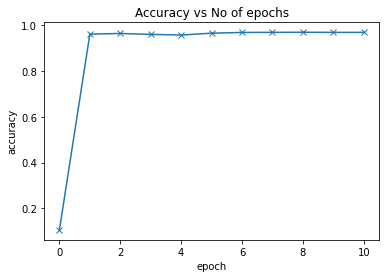

In [122]:
accuracies = [val_acc]+ metrics1+metrics2
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No of epochs')